In [6]:
# =================================================
# demo3: detection_and_attribution_analysis
# =================================================

import cmaps
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
from scipy import linalg
from sklearn.linear_model import LinearRegression
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import BoundaryNorm, ListedColormap
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 18

In [7]:
MDRs = [
    {'name': 'WNP', 'lon_min': 120, 'lon_max': 160, 'lat_min': 5, 'lat_max': 25},   # Western North Pacific
    {'name': 'ENP', 'lon_min': 240, 'lon_max': 270, 'lat_min': 5, 'lat_max': 20},   # Eastern North Pacific
    {'name': 'NA', 'lon_min': 310, 'lon_max': 345, 'lat_min': 5, 'lat_max': 20},    # North Atlantic
    {'name': 'SI', 'lon_min': 55, 'lon_max': 105, 'lat_min': -15, 'lat_max': -5},   # South Indian
    {'name': 'SP', 'lon_min': 150, 'lon_max': 190, 'lat_min': -20, 'lat_max': -5},  # South Pacific
    {'name': 'NI', 'lon_min': 60, 'lon_max': 95, 'lat_min': 5, 'lat_max': 20},      # North Indian
]

# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_aer_trends():
    """
    Plot AER simulation trends with significance masking and MDR regions.
    
    Returns:
        fig, ax: matplotlib figure and axis objects
    """
    # Load data
    aer_data = xr.open_dataset('aer.nc')
    aer_trend = np.load('aer_trend.npy')
    significance_mask = np.load('pvalues_aer.npy')
    
    # Create figure
    fig = plt.figure(figsize=(12, 8), dpi=500)
    proj = ccrs.PlateCarree(central_longitude=180)
    ax = fig.subplots(1, 1, subplot_kw={'projection': proj})
    
    # Configure map features
    ax.add_feature(cfeature.COASTLINE, ec='k', lw=0.8)
    ax.add_feature(cfeature.LAND, fc='w')
    
    # Configure colormap and normalization
    cmap = plt.cm.RdBu_r
    cmap = ListedColormap(cmap(np.linspace(0, 1, 12)))
    norm = BoundaryNorm(boundaries=np.linspace(-0.15, 0.15, 13), 
                       ncolors=12, extend='neither')
    
    # Mask non-significant trends
    trend_masked = np.where((aer_trend < 0.01) & (aer_trend > -0.01), 
                           np.nan, aer_trend)
    
    # Plot trend data
    pmesh = ax.pcolormesh(aer_data.lon, aer_data.lat, trend_masked,
                         transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    
    # Plot significance markers
    lons, lats = np.meshgrid(aer_data.lon, aer_data.lat)
    ax.scatter(lons[significance_mask], lats[significance_mask], 
              c='k', marker='o', s=6, transform=ccrs.PlateCarree())
    
    # Configure colorbar
    cbar = fig.colorbar(pmesh, ax=ax, orientation='horizontal', 
                       pad=0.08, aspect=50)
    cbar.ax.set_xlabel('Annual Trend', fontsize=18, labelpad=5)
    cbar.ax.grid(True, which='both', axis='both', lw=1.5, linestyle='-', color='k')
    cbar.ax.tick_params(axis='x', which='both', length=0, width=0)
    
    # Style colorbar spines
    for spine in cbar.ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Configure map extent and grid
    ax.set_extent([-180, 180, -50, 50], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(-180, 181, 60))
    ax.set_yticks(np.arange(-50, 51, 25))
    ax.set_xticks(np.arange(-180, 181, 20), minor=True)
    ax.set_xticklabels(['0°', '60°E', '120°E', '180°', '120°W', '60°W', '0°'])
    ax.set_yticklabels(['50°S', '25°S', '0°', '25°N', '50°N'])
    
    # Configure tick parameters
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(which='major', length=10, width=1.5, 
                           color='k', direction='out')
        axis.set_tick_params(which='minor', length=5, width=1, 
                           color='k', direction='out')
    
    # Add equator line
    ax.plot([-180, 180], [0, 0], transform=ccrs.PlateCarree(), 
           color='grey', ls='--')
    
    # Style plot spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('k')
    
    # Add MDR regions
    for mdr in MDRs:
        rectangle = patches.Rectangle(
            (mdr['lon_min'], mdr['lat_min']), 
            mdr['lon_max'] - mdr['lon_min'], 
            mdr['lat_max'] - mdr['lat_min'],
            ls='-', lw=1.5, ec='r', fc='none', 
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(rectangle)
    
    ax.set_title('AER Simulations: Trend Analysis', fontsize=20)
    plt.tight_layout()
    
    return fig, ax

def plot_fingerprinting_results():
    """
    Plot optimal fingerprinting results using TLS method.
    
    Returns:
        fig, ax: matplotlib figure and axis objects
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Configuration parameters
    bar_width = 0.2
    colors = ['#E64B35FF', '#14AD96FF', '#3C5488FF', '#EC9E27', '#979595']
    
    # Results data: [index, lower_ci, upper_ci, mean_value]
    results_data = np.array([
        [0, 0.2, 1.5, 0.8],      # ALL forcings
        [1, -0.7, 0.75, 0.11],   # NATural
        [2, 0.4, 1.5, 1.1],      # ANTthropogenic
        [3, -0.4, -0.1, -0.24],  # GreenHouse Gases
        [4, 0.2, 0.7, 0.42],     # AERosols
    ])
    
    # Plot confidence intervals and means
    for (x_pos, lower, upper, mean_val), color in zip(results_data, colors):
        height = upper - lower
        if height < 0:
            lower, upper = upper, lower
            height = -height
        
        # Plot confidence interval bar
        ax.bar(x_pos, height, width=bar_width, align='center', 
               color=color, bottom=lower)
        
        # Plot mean value line
        ax.hlines(mean_val, x_pos - bar_width / 2, x_pos + bar_width / 2, 
                 colors='w', linestyles='-', lw=2.5)
    
    # Add reference lines
    ax.axhline(y=0, color='k', alpha=0.4, lw=1.5, linestyle='--')
    ax.axhline(y=1, color='k', alpha=0.4, lw=1.5, linestyle='--')
    
    # Configure axes
    ax.set_xlim([-0.5, 4.5])
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_ylim([-1, 2])
    ax.set_yticks([-1, 0, 1, 2])
    ax.set_xticklabels(['ALL', 'NAT', 'ANT', 'GHG', 'AER'])
    ax.set_ylabel('Scaling Factor', fontsize=20)
    
    # Configure tick parameters
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=18)
    
    # Style ticks
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(which='major', length=6, width=1.5, 
                           color='k', direction='out')
        axis.set_tick_params(which='minor', length=4, width=1.5, 
                           color='k', direction='out')
    
    # Style plot spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    ax.set_title('Global: One-signal Analysis (TLS)', fontsize=22)
    plt.tight_layout()
    
    return fig, ax

In [8]:
# =============================================================================
# STATISTICAL ANALYSIS FUNCTIONS
# =============================================================================

def optimal_fingerprinting(y, X, pictrl, reg_method, n_boot=1000, 
                          ci_range=(2.5, 97.5), random_seed=None):
    """
    Perform optimal fingerprinting analysis using OLS or TLS regression.
    
    Parameters:
    -----------
    y : array-like
        Response variable (observations)
    X : array-like
        Predictor variable(s) (model simulations)
    pictrl : array-like
        Pre-industrial control runs for uncertainty estimation
    reg_method : str
        Regression method: 'OLS' or 'TLS'
    n_boot : int
        Number of bootstrap samples
    ci_range : tuple
        Confidence interval range (lower, upper)
    random_seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    dict : Results containing beta estimates, confidence intervals, and p-values
    """
    # Convert xarray DataArrays to numpy arrays if needed
    y = y.values if isinstance(y, xr.DataArray) else y
    X = X.values if isinstance(X, xr.DataArray) else X
    pictrl = pictrl.values if isinstance(pictrl, xr.DataArray) else pictrl
    
    # Ensure X is 2D
    X = X.reshape(-1, 1) if X.ndim == 1 else X
    
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Perform regression
    if reg_method == 'OLS':
        beta = LinearRegression(fit_intercept=False).fit(X, y).coef_
    
    elif reg_method == 'TLS':
        Z = np.column_stack([X, y])
        _, _, Vh = linalg.svd(Z, full_matrices=False)
        V = Vh.T
        beta = (-V[:X.shape[1], X.shape[1]:] / V[X.shape[1]:, X.shape[1]:]).flatten()
    
    else:
        raise ValueError("reg_method must be 'OLS' or 'TLS'")
    
    # Initialize results dictionary
    results = {'beta': beta}
    
    # Bootstrap confidence intervals
    boot_beta = np.zeros([n_boot, X.shape[1]])
    
    for i in range(n_boot):
        # Create bootstrap sample by adding pre-industrial control variability
        y_boot = y + np.random.choice(pictrl, size=len(y))
        
        if reg_method == 'OLS':
            boot_beta[i] = LinearRegression(fit_intercept=False).fit(X, y_boot).coef_
        else:
            Z_boot = np.column_stack([X, y_boot])
            _, _, Vh_boot = linalg.svd(Z_boot, full_matrices=False)
            V_boot = Vh_boot.T
            boot_beta[i] = (-V_boot[:X.shape[1], X.shape[1]:] / 
                           V_boot[X.shape[1]:, X.shape[1]:]).flatten()
    
    # Calculate confidence intervals and p-values
    results.update({
        'ci_lower': np.percentile(boot_beta, ci_range[0], axis=0),
        'ci_upper': np.percentile(boot_beta, ci_range[1], axis=0),
        'p_values': np.minimum(
            np.minimum((boot_beta < 0).mean(axis=0),
                      (boot_beta > 0).mean(axis=0)), 1)
    })
    
    return results

def print_results(results, reg_method, forcing_name=""):
    """
    Print optimal fingerprinting results in a formatted table.
    
    Parameters:
    -----------
    results : dict
        Results from optimal_fingerprinting function
    reg_method : str
        Regression method used
    forcing_name : str
        Name of the forcing being analyzed
    """
    print(f"\nOptimal Fingerprinting using {reg_method} - {forcing_name}")
    print(f"{'Forcing':<15} {'Beta':>10} {'CI[5-95%]':>20} {'p-value':>10}")
    print('-' * 60)
    
    for i, beta in enumerate(results['beta']):
        ci_lower = results.get('ci_lower', [np.nan] * len(results['beta']))[i]
        ci_upper = results.get('ci_upper', [np.nan] * len(results['beta']))[i]
        p_value = results.get('p_values', [np.nan] * len(results['beta']))[i]
        
        ci_str = f"[{ci_lower:.2f}, {ci_upper:.2f}]" if not np.isnan(ci_lower) else "N/A"
        p_str = f"{p_value:.3f}" if not np.isnan(p_value) else "N/A"
        
        forcing_label = f'Fingerprint {i+1}' if forcing_name == "" else forcing_name
        print(f"{forcing_label:<15} {beta:>10.2f} {ci_str:>20} {p_str:>10}")

Starting Detection and Attribution Analysis...

PART 1: AER Simulation Trend Analysis


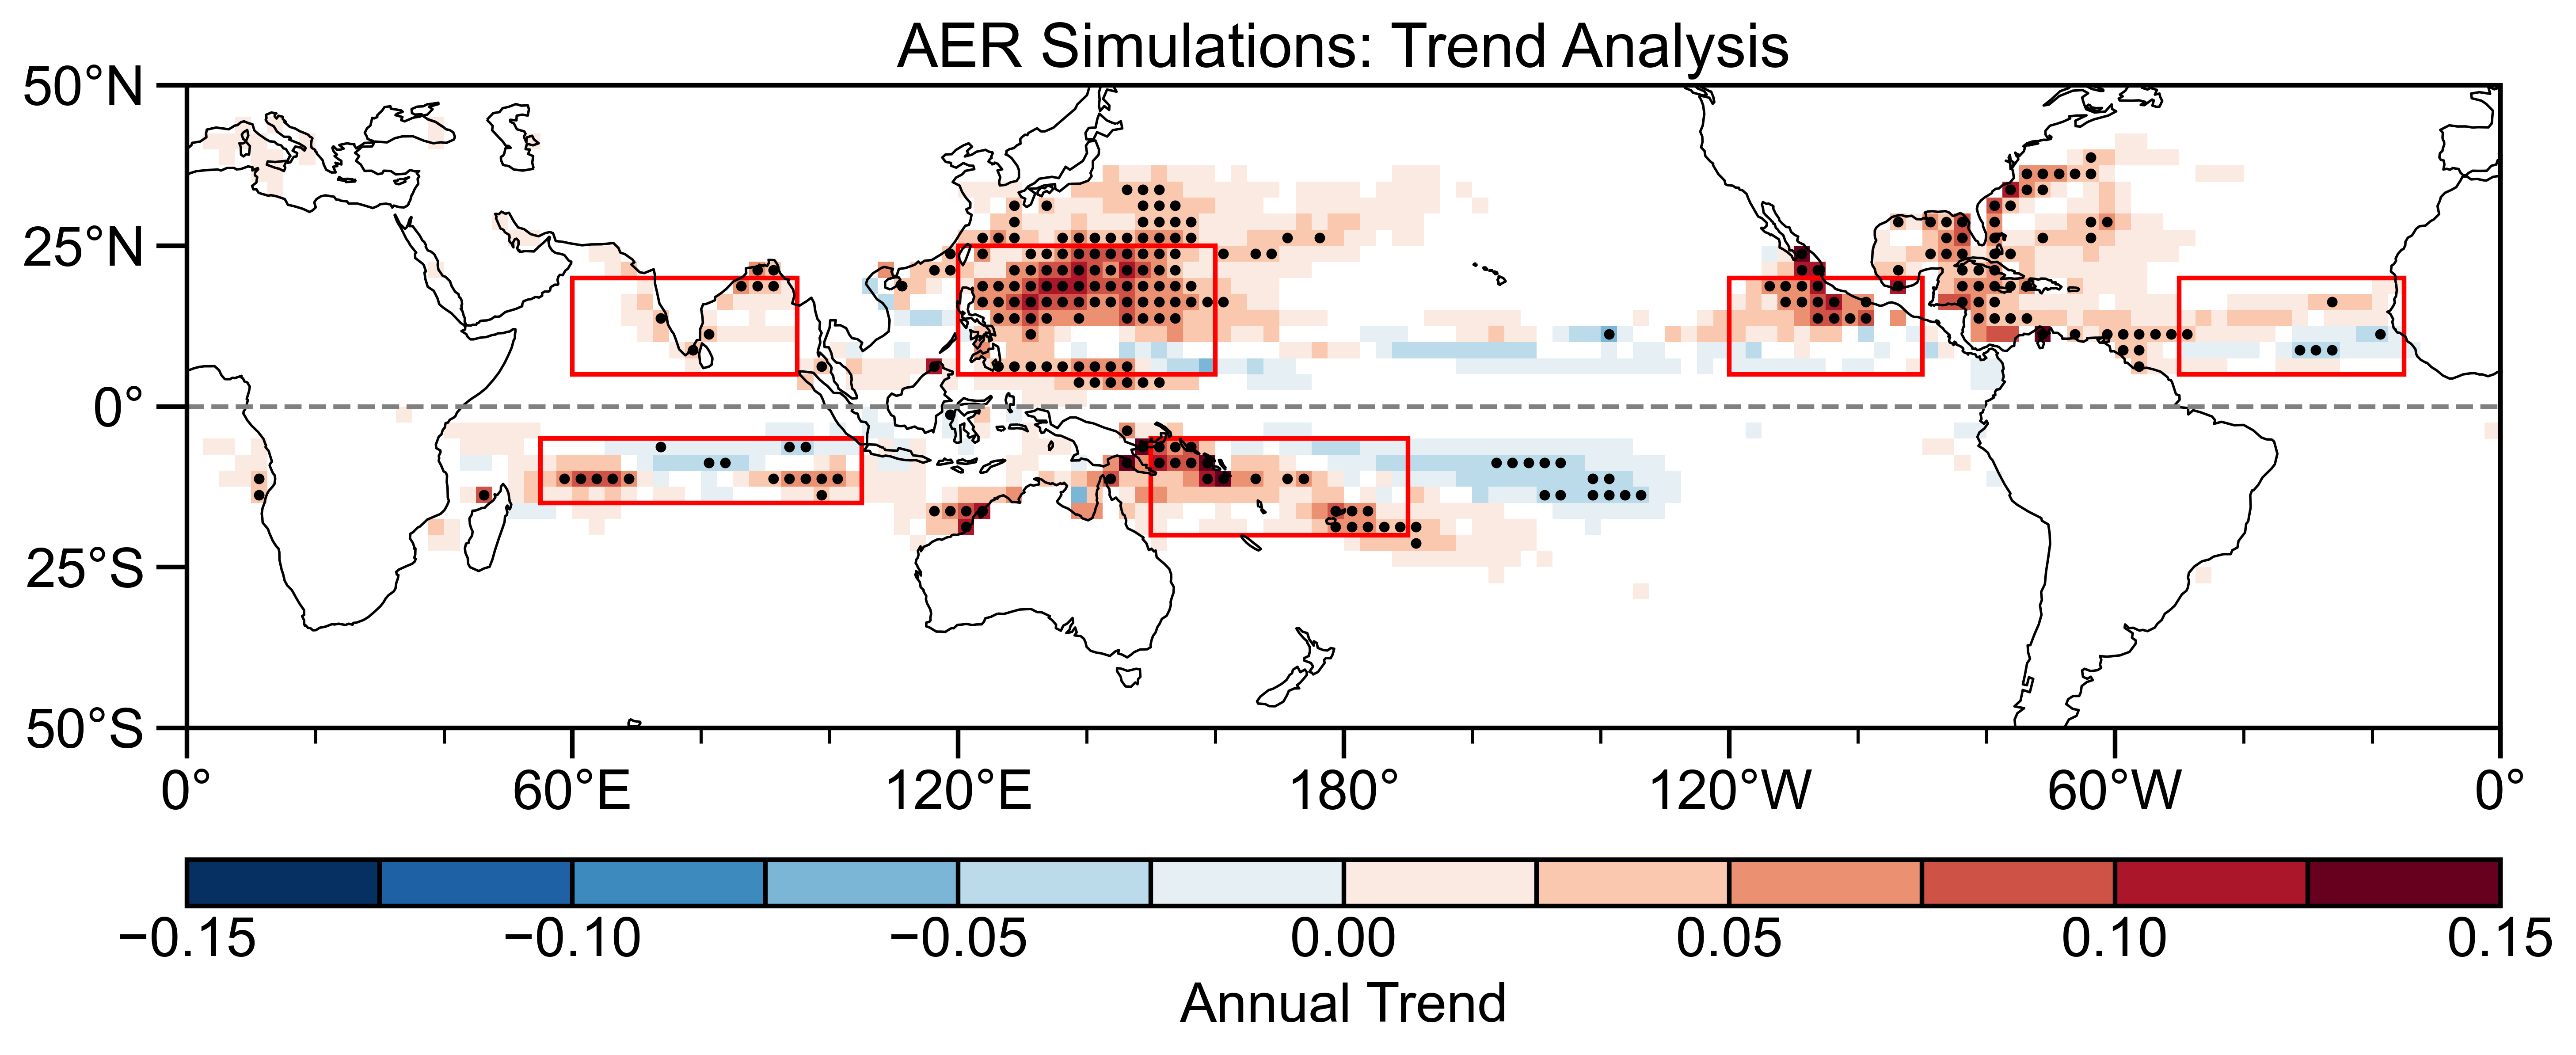


PART 2: Optimal Fingerprinting Analysis
Loading data files...

Analyzing Natural Forcing...

Optimal Fingerprinting using OLS - NAT
Forcing               Beta            CI[5-95%]    p-value
------------------------------------------------------------
NAT                   0.03        [-0.31, 0.35]      0.433

Optimal Fingerprinting using TLS - NAT
Forcing               Beta            CI[5-95%]    p-value
------------------------------------------------------------
NAT                   0.11      [-69.96, 78.67]      0.447

Analyzing Greenhouse Gas Forcing...

Optimal Fingerprinting using OLS - GHG
Forcing               Beta            CI[5-95%]    p-value
------------------------------------------------------------
GHG                  -0.13        [-0.41, 0.14]      0.163

Optimal Fingerprinting using TLS - GHG
Forcing               Beta            CI[5-95%]    p-value
------------------------------------------------------------
GHG                  -0.24      [-22.87, 35.84]      

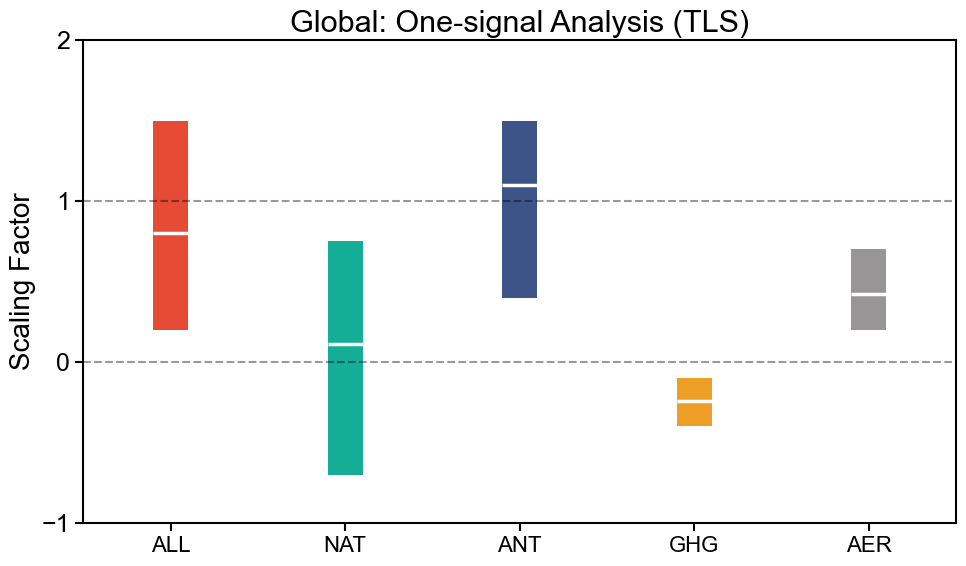


Analysis completed successfully!


In [9]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function for detection and attribution analysis."""
    
    print("Starting Detection and Attribution Analysis...")
    
    # =========================================================================
    # PART 1: AER TREND VISUALIZATION
    # =========================================================================
    print("\n" + "="*50)
    print("PART 1: AER Simulation Trend Analysis")
    print("="*50)
    
    fig1, ax1 = plot_aer_trends()
    plt.show()
    
    # =========================================================================
    # PART 2: OPTIMAL FINGERPRINTING ANALYSIS
    # =========================================================================
    print("\n" + "="*50)
    print("PART 2: Optimal Fingerprinting Analysis")
    print("="*50)
    
    # Load data for fingerprinting analysis
    print("Loading data files...")
    y = xr.open_dataset('obs_TCF.nc').__xarray_dataarray_variable__
    X_nat = xr.open_dataset('nat_TCF.nc').__xarray_dataarray_variable__
    X_ghg = xr.open_dataset('ghg_TCF.nc').__xarray_dataarray_variable__
    X_aer = xr.open_dataset('aer_TCF.nc').__xarray_dataarray_variable__
    pictrl = xr.open_dataset('pictrl_TCF.nc').__xarray_dataarray_variable__
    
    # Natural forcing analysis
    print("\nAnalyzing Natural Forcing...")
    res_ols_nat = optimal_fingerprinting(y, X_nat, pictrl, reg_method='OLS', n_boot=1000)
    res_tls_nat = optimal_fingerprinting(y, X_nat, pictrl, reg_method='TLS', n_boot=1000)
    print_results(res_ols_nat, 'OLS', 'NAT')
    print_results(res_tls_nat, 'TLS', 'NAT')
    
    # Greenhouse gas forcing analysis
    print("\nAnalyzing Greenhouse Gas Forcing...")
    res_ols_ghg = optimal_fingerprinting(y, X_ghg, pictrl, reg_method='OLS', n_boot=1000)
    res_tls_ghg = optimal_fingerprinting(y, X_ghg, pictrl, reg_method='TLS', n_boot=1000)
    print_results(res_ols_ghg, 'OLS', 'GHG')
    print_results(res_tls_ghg, 'TLS', 'GHG')
    
    # Aerosol forcing analysis
    print("\nAnalyzing Aerosol Forcing...")
    res_ols_aer = optimal_fingerprinting(y, X_aer, pictrl, reg_method='OLS', n_boot=1000)
    res_tls_aer = optimal_fingerprinting(y, X_aer, pictrl, reg_method='TLS', n_boot=1000)
    print_results(res_ols_aer, 'OLS', 'AER')
    print_results(res_tls_aer, 'TLS', 'AER')
    
    # =========================================================================
    # PART 3: FINGERPRINTING RESULTS VISUALIZATION
    # =========================================================================
    print("\n" + "="*50)
    print("PART 3: Visualization of Fingerprinting Results")
    print("="*50)
    
    fig2, ax2 = plot_fingerprinting_results()
    plt.show()
    
    print("\nAnalysis completed successfully!")

if __name__ == "__main__":
    main()